In [1]:
#Connect to our own Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


https://pypi.org/project/sentence-transformers/

In [2]:
%cd "/content/gdrive/My Drive/ProjetNLPQuora/"
!ls


/content/gdrive/My Drive/ProjetNLPQuora
bert-master  embq1.csv		  model_w2c_6.h5  train.csv
cache	     glove.840B.300d.txt  test.csv


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


df_train = pd.read_csv("train.csv")

In [0]:
# CLEANING TO COMPUTE EMBEDDINGS NOT NECESSARY IF WE ALREADY COMPUTED THEM
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)

df_train["question1"] = df_train["question1"].astype("str")
df_train["question2"] = df_train["question2"].astype('str')

q1 = df_train['question1'].tolist()
q2 = df_train['question2'].tolist()


In [5]:
! pip install sentence-transformers

     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 645kB 7.0MB/s 
     |████████████████████████████████| 1.1MB 20.1MB/s 
     |████████████████████████████████| 3.8MB 15.7MB/s 
     |████████████████████████████████| 890kB 36.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=32129c04c77442cd8abd58a963b4a0998ba1152c34aab96613af499260f82b43
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=67b9a4c40f948c53c7b5861a887dd7a4db73d57dd8799ace0dce3df6edd54414
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:17<00:00, 23.8MB/s]


In [7]:
### VECTORIZING QUESTIONS DF_TRAIN ###
t1 = time.time()
print("Computing embeddings for q1 train")
embq1 = model.encode(q1)
t2 = time.time()-t1
print(t2,"seconds", t2/60, "minutes" )

t3 = time.time()
print("Computing embeddings for q2 train ")
embq2 = model.encode(q2)
t4 = time.time()-t3
print(t4,"seconds", t4/60, "minutes" )

print('Total time',time.time()-t1,"seconds", (time.time()-t1)/60, "minutes" )

Computing embeddings for q1 train
1617.2138781547546 seconds 26.953564635912578 minutes
Computing embeddings for q2 train 
1625.7037892341614 seconds 27.09506315390269 minutes
Total time 3242.9192531108856 seconds 54.04865422646205 minutes


In [0]:
#embq1 = np.array(embq1)
#embq2 = np.array(embq2)

#np.save('../embeddings/SBERT1.npy', embq1)
#np.save('../embeddings/SBERT2.npy', embq2)

In [0]:
df_train['emb1'] = embq1
df_train['emb2'] = embq2

datatrain = df_train[:320000] 
datatest = df_train[320000:]
datatest = datatest.reset_index(drop=True)


In [10]:
sim = []
for i in range(datatrain.shape[0]):
  if (i % 50000 == 0):
    print(100 * i/datatrain.shape[0], "% done")
  cosine = np.dot(embq1[i],embq2[i].transpose()) / (np.linalg.norm(embq1[i]) * np.linalg.norm(embq2[i]))
  #sim.append(1/(1 + math.exp(-100*(cosine - 0.85))))
  sim.append(cosine)

0.0 % done
15.625 % done
31.25 % done
46.875 % done
62.5 % done
78.125 % done
93.75 % done


In [0]:
th = []
t2 = []
for i in range(200):
  t = .8 + 0.001*i
  dupl2 = (np.asarray(sim)>t)*1 
  th.append(sum(datatrain['is_duplicate']== dupl2)/datatrain.shape[0])
  t2.append(t)

Text(0, 0.5, 'Accuracy')

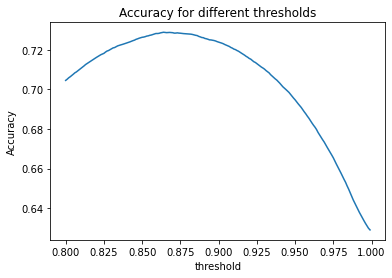

In [17]:
from matplotlib import pyplot as plt
plt.plot(t2, th)
 
plt.title('Accuracy for different thresholds')
plt.xlabel('threshold')
plt.ylabel('Accuracy')


In [21]:
optimal_th =  .8 + 0.001*np.argmax(th)
accuracy_max = max(th)
print(optimal_th, accuracy_max)

0.8640000000000001 0.72894375


In [19]:
# TESTING 
simtest = []
for i in range(datatest.shape[0]):
  if (i % 10000 == 0):
    print(100 * i/datatest.shape[0], "% done")
  cosine = np.dot(datatest['emb1'][i],datatest['emb2'][i].transpose()) / (np.linalg.norm(datatest['emb1'][i]) * np.linalg.norm(datatest['emb2'][i]))
  #sim.append(1/(1 + math.exp(-100*(cosine - 0.85))))
  simtest.append(cosine)

0.0 % done
11.864225799945425 % done
23.72845159989085 % done
35.592677399836276 % done
47.4569031997817 % done
59.32112899972712 % done
71.18535479967255 % done
83.04958059961797 % done
94.9138063995634 % done


In [20]:
dupltest = (np.asarray(simtest)>optimal_th)*1 
print(sum(datatest['is_duplicate']== dupltest)/datatest.shape[0])

0.7305159751800396
